# Debug - RSSI has very high probability to be detected in low dBm range (-85~-99 dbm)

<img src="./imgs/many_weak_signal_strength_samples_is_detected.PNG" alt="alt_text" width="500" align="center"/>

### Root Causes

#### Root Cause 1 : Bug on calculating Radiance

When calculate the TraceTransmitter() shader method, it doesn't divide 4\*PI for the radiance calculation. 

Hence, we change the GetPower() method to return the tx power at transmitter not at 1 meter distance. Now, the radiance is calculated by

$$\text{Radiance} = \frac{\text{TX_POWER}_\text{dBm}}{4\pi d^2} $$

Hence it doesn't depend on the radius and size of the TX itself

In [35]:
import numpy as np

# helper function
def dBmTomW(dBm):
    return np.power(10, dBm * 0.1)
def mWtodBm(mW):
    return 10 * np.log10(mW)

def radiance(tx_power_dBm, distance):
    mW = dBmTomW(tx_power_dBm)
    mW = mW / (4*np.pi*distance*distance)
    return mWtodBm(mW)
"%d dBm" % radiance(-20, 10) # -20 dBm signal at 10 meter for point source (isotropic antenna)

'-50 dBm'

According our emprical data, the RSSI at 1 meter should around -67 dBm for BLE beacon. The RSSI will also affect by the system gain. Here we choose the wireless communication system with tx power -10 dBm with -45 dBm system gain as example

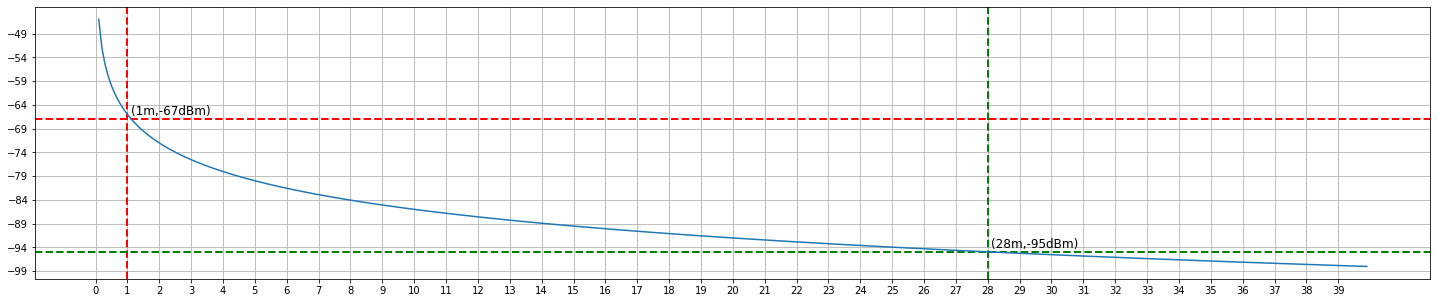

In [85]:
import matplotlib.pyplot as plt
TX_POWER = -10
SYS_GAIN = -45
def f(x):
    return radiance(TX_POWER, x) + SYS_GAIN
x = np.arange(0.1, 40, 0.1)
y = f(x)
fig, ax = plt.subplots(figsize=(25, 5))
ax.grid(True, linestyle='-')
# auxiliary lines at 1 meters
p1, p2 = (1,-67), (28,-95)
X_OFFSET, Y_OFFSET = 0.1, 1
plt.axvline(x=p1[0], c='r', ls='--', lw=2)
plt.axhline(y=p1[1], c='r', ls='--', lw=2)
plt.axvline(x=p2[0], c='g', ls='--', lw=2)
plt.axhline(y=p2[1], c='g', ls='--', lw=2)
plt.text(p1[0]+X_OFFSET, p1[1]+Y_OFFSET, s='(1m,-67dBm)', fontsize=12)
plt.text(p2[0]+X_OFFSET, p2[1]+Y_OFFSET, s='(28m,-95dBm)', fontsize=12)
plt.xticks(np.arange(0, 40, 1))
plt.yticks(np.arange(np.floor(np.min(y)), np.ceil(np.max(y)), 5))
_ = plt.plot(x, y)

#### Root Cause 2: Weaker signal has same probability being sample as the area of interest

The probability distribution on receiver ray direction is uniform distribution on all direction (spherical surface normal).

In practice, the direction with stronger incoming signal will have higher chances to be detected due to the packet reception mechnism in real wireless sensor network. The weaker signal will have higher error bit rate, it will be abandon by receiver (physical layer, MAC)

RX sensitivity theshold ensure the packet error rate (PER) less then 1% when signal above the threshold.[1] which mean there are still 99% changes the packet will be accepted.

However, according to this research [2], the packet reception rate (PRR) drop dramatically around -92 dBm. Coincidentally, this value is between the RX sensitivity theshold -90 dBm (min) ~ -95 dBm (=typical) for RF chip cc2420. According to their result, the PRR almost reach to zero.

Hence, we apply a mask after first the round wi tracing (sampling on pixel) thought all bounces, then for signal less than RX sensitivity threshold, we sample on a probability to determine if we need to termiate the trace process.

We assume the probability of packet to be rejected is linear between -85 dBm to -95 dBm which start from 1 at -85 dBm and end up with 0 at -95 dBm. Then we can from a probability equation that describe this:

$$P_\text{Reject} = \frac{\text{RSSI}-\text{RSSI}_\text{TotalReject}} {\text{RSSI}_\text{TotalAccept} -\text{RSSI}_\text{TotalReject}} $$

In [122]:
TOTAL_ACCEPT_RSSI = -85
TOTAL_REJECT_RSSI = -95

def probability_of_accept(x):
    p = (x - TOTAL_REJECT_RSSI) / (TOTAL_ACCEPT_RSSI - TOTAL_REJECT_RSSI)
    if type(x).__module__ == np.__name__ :
        p[p>1]=1
        p[p<0]=0
    else:
        if p > 1:
            p = 1
        if p < 0:
            p = 0
    return p
probability_of_accept(-80), probability_of_accept(-87), probability_of_accept(-99)

(1, 0.8, 0)

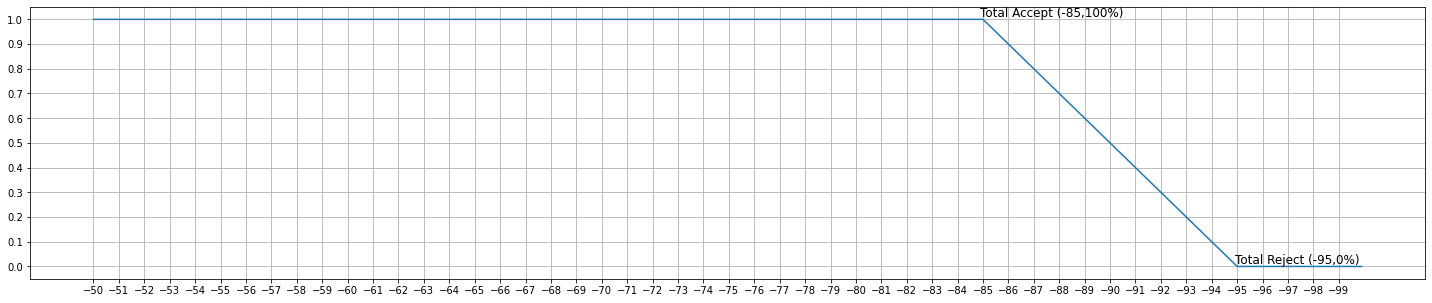

In [130]:
x = np.arange(-50, -100, -0.1)
y = probability_of_accept(x)
fig, ax = plt.subplots(figsize=(25, 5))
ax.grid(True, linestyle='-')
ax.invert_xaxis()
plt.xticks(np.arange(-50, -100, -1))
plt.yticks(np.arange(0, 1.1, 0.1))

p1, p2 = (-85,1), (-95,0)
X_OFFSET, Y_OFFSET = 0.1, 0.01
plt.text(p1[0]+X_OFFSET, p1[1]+Y_OFFSET, s='Total Accept (-85,100%)', fontsize=12)
plt.text(p2[0]+X_OFFSET, p2[1]+Y_OFFSET, s='Total Reject (-95,0%)', fontsize=12)
_ = plt.plot(x, y)

REFERENCES:   
[1] 2.4 GHz IEEE 802.15.4 / ZigBee-ready RF Transceiver https://www.ti.com/lit/ds/symlink/cc2420.pdf   
[2] Srinivasan, Kannan, and Philip Levis. "RSSI is under appreciated." Proceedings of the third workshop on embedded networked sensors (EmNets). Vol. 2006. 2006.

## Result

Better but have not fully solved